In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import foolbox as fb
from foolbox.attacks import LinfAdamBasicIterativeAttack
from foolbox.attacks import FGSM
from foolbox.attacks import MIFGSM
from foolbox.attacks import PGD
from foolbox.attacks import L2CarliniWagnerAttack

import eagerpy as ep
from foolbox.utils import accuracy

import time

In [10]:
loaded_mnist = tf.keras.models.load_model("mnist-model.keras")

num_classes = 10

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_test = x_test.astype("float32") / 255
x_test = np.expand_dims(x_test, -1)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)     # No need for one-hot encoding with Foolbox

# Convert labels to the correct type for EagerPy
y_test = y_test.astype(np.int64)

# Convert test images and labels to TensorFlow tensors
x_test_tf = tf.convert_to_tensor(x_test)
y_test_tf = tf.convert_to_tensor(y_test)

In [3]:
bounds = (0, 1)
preprocessing = dict()
fmodel = fb.TensorFlowModel(loaded_mnist, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [11]:
# Convert test images and labels to EagerPy tensors
images, labels = ep.astensors(x_test_tf, y_test_tf)

# Check accuracy on clean images
clean_acc = accuracy(fmodel, images, labels)
print(f"Clean accuracy: {clean_acc * 100:.1f} %")

Clean accuracy: 99.2 %


In [5]:
epsilon = [0.1]
eps_iter = 0.03
iter=40

In [12]:
fgsm_attack = FGSM(random_start=False)
mim_attack = MIFGSM(random_start=False, rel_stepsize=eps_iter, steps=iter)
pgd_attack = PGD(random_start=False, rel_stepsize=eps_iter, steps=iter)
bim_attack = LinfAdamBasicIterativeAttack(random_start=False, rel_stepsize=eps_iter, steps=iter)

In [7]:
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

In [8]:
def apply_attack_and_measure_time(attack, attack_name, fmodel, images, labels, epsilon):

    # Measure execution time
    start_time = time.time()

    # Apply the attack
    raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)

    end_time = time.time()
    execution_time = end_time - start_time
    formatted_time = format_time(execution_time)

    # Calculate robust accuracy
    robust_accuracy = 1 - success.float32().mean(axis=-1)

    # Convert TensorFlow tensor to numpy array
    robust_accuracy_np = robust_accuracy.numpy()[0] * 100

    # Prepare results with attack_name prefix
    x_adversarial_dict = {f'{attack_name}_adv': clipped_advs}
    attack_info = {
        f'{attack_name}_acc': round(robust_accuracy_np, 2),
        f'{attack_name}_time': formatted_time,
        
    }

    return x_adversarial_dict, attack_info

In [13]:
fgsm_adv, fgsm_info = apply_attack_and_measure_time(fgsm_attack, attack_name="FGSM", fmodel=fmodel, images=images, labels=labels, epsilon=epsilon)

In [10]:
mim_adv, mim_info = apply_attack_and_measure_time(mim_attack, "MIM", fmodel=fmodel, images=images, labels=labels, epsilon=epsilon)

In [11]:
pgd_adv, pgd_info = apply_attack_and_measure_time(pgd_attack, "PGD", fmodel=fmodel, images=images, labels=labels, epsilon=epsilon)

In [12]:
bim_adv, bim_info = apply_attack_and_measure_time(bim_attack, "BIM", fmodel=fmodel, images=images, labels=labels, epsilon=epsilon)

In [15]:
# Combine all adversarial data and attack info into single dictionaries
x_adversarial_dict = {**fgsm_adv, **bim_adv,  **mim_adv, **pgd_adv}
attack_info = {**fgsm_info, **bim_info, **mim_info, **pgd_info}

In [70]:
from typing import Dict, List, Any

def visualize_adversarial_attacks(
    library_name: str,
    x_test: np.ndarray,
    x_adversarial_dict: Dict[str, List[tf.Tensor]],
    attack_info: Dict[str, Any],
    indices: List[int]
):
    num_samples = len(indices)

    # Select samples to visualize using provided indices
    originals = x_test[indices]

    # Number of attacks to visualize
    attack_names = [key.replace('_adv', '') for key in x_adversarial_dict.keys()]
    num_attacks = len(attack_names)

    # Calculate the number of rows needed for two columns
    num_rows = (num_attacks + 1) // 2

    fig = plt.figure(layout="constrained", figsize=(15,15))
    fig.suptitle(f'Wizualizacja ataków zwodniczych ({library_name})', fontsize=17)
    subfigs = fig.subfigures(num_rows, 2, wspace=0.07)
    subfigs = subfigs.flatten()

    for i in range(len(subfigs)): # pierwszy atak pozniej kolejny i kolejny
        
        adversarials = x_adversarial_dict[f'{attack_names[i]}_adv'][0]
        accuracy = attack_info[f'{attack_names[i]}_acc']
        compile_time = attack_info[f'{attack_names[i]}_time']   
        subfigs[i].suptitle(f'{attack_names[i]}\nDokładność modelu po ataku: {accuracy}%\n Czas kompilacji: {compile_time} (mm:ss)', fontsize=16)
        
        
        axs = subfigs[i].subplots(3, 3)
        axs[0, 0].set_title('Oryginał', fontsize=16)
        axs[0, 1].set_title('Po ataku', fontsize=16)
        axs[0, 2].set_title('Zakłócenia', fontsize=16)
    
        row_offset = 0
        col_offset = 0
        
        for j in range(num_samples):
            # Convert TensorFlow tensors to numpy arrays
            original_image_np = originals[j]
            adversarial_image_np = adversarials[indices[j]].numpy()
            difference_image_np = (adversarial_image_np - original_image_np).reshape(28, 28)

            # Original image
            axs[row_offset, col_offset].imshow(original_image_np.reshape(28, 28), cmap='gray')
            axs[row_offset, col_offset].axis("off")
            # Adversarial image
            axs[row_offset, col_offset + 1].imshow(adversarial_image_np.reshape(28, 28), cmap='gray')
            axs[row_offset, col_offset+1].axis("off")    
            # Difference image
            axs[row_offset, col_offset + 2].imshow(difference_image_np, cmap='gray')
            axs[row_offset, col_offset+2].axis("off")
            
            row_offset += 1
        
        
        row_offset = 0
        col_offset = 0 

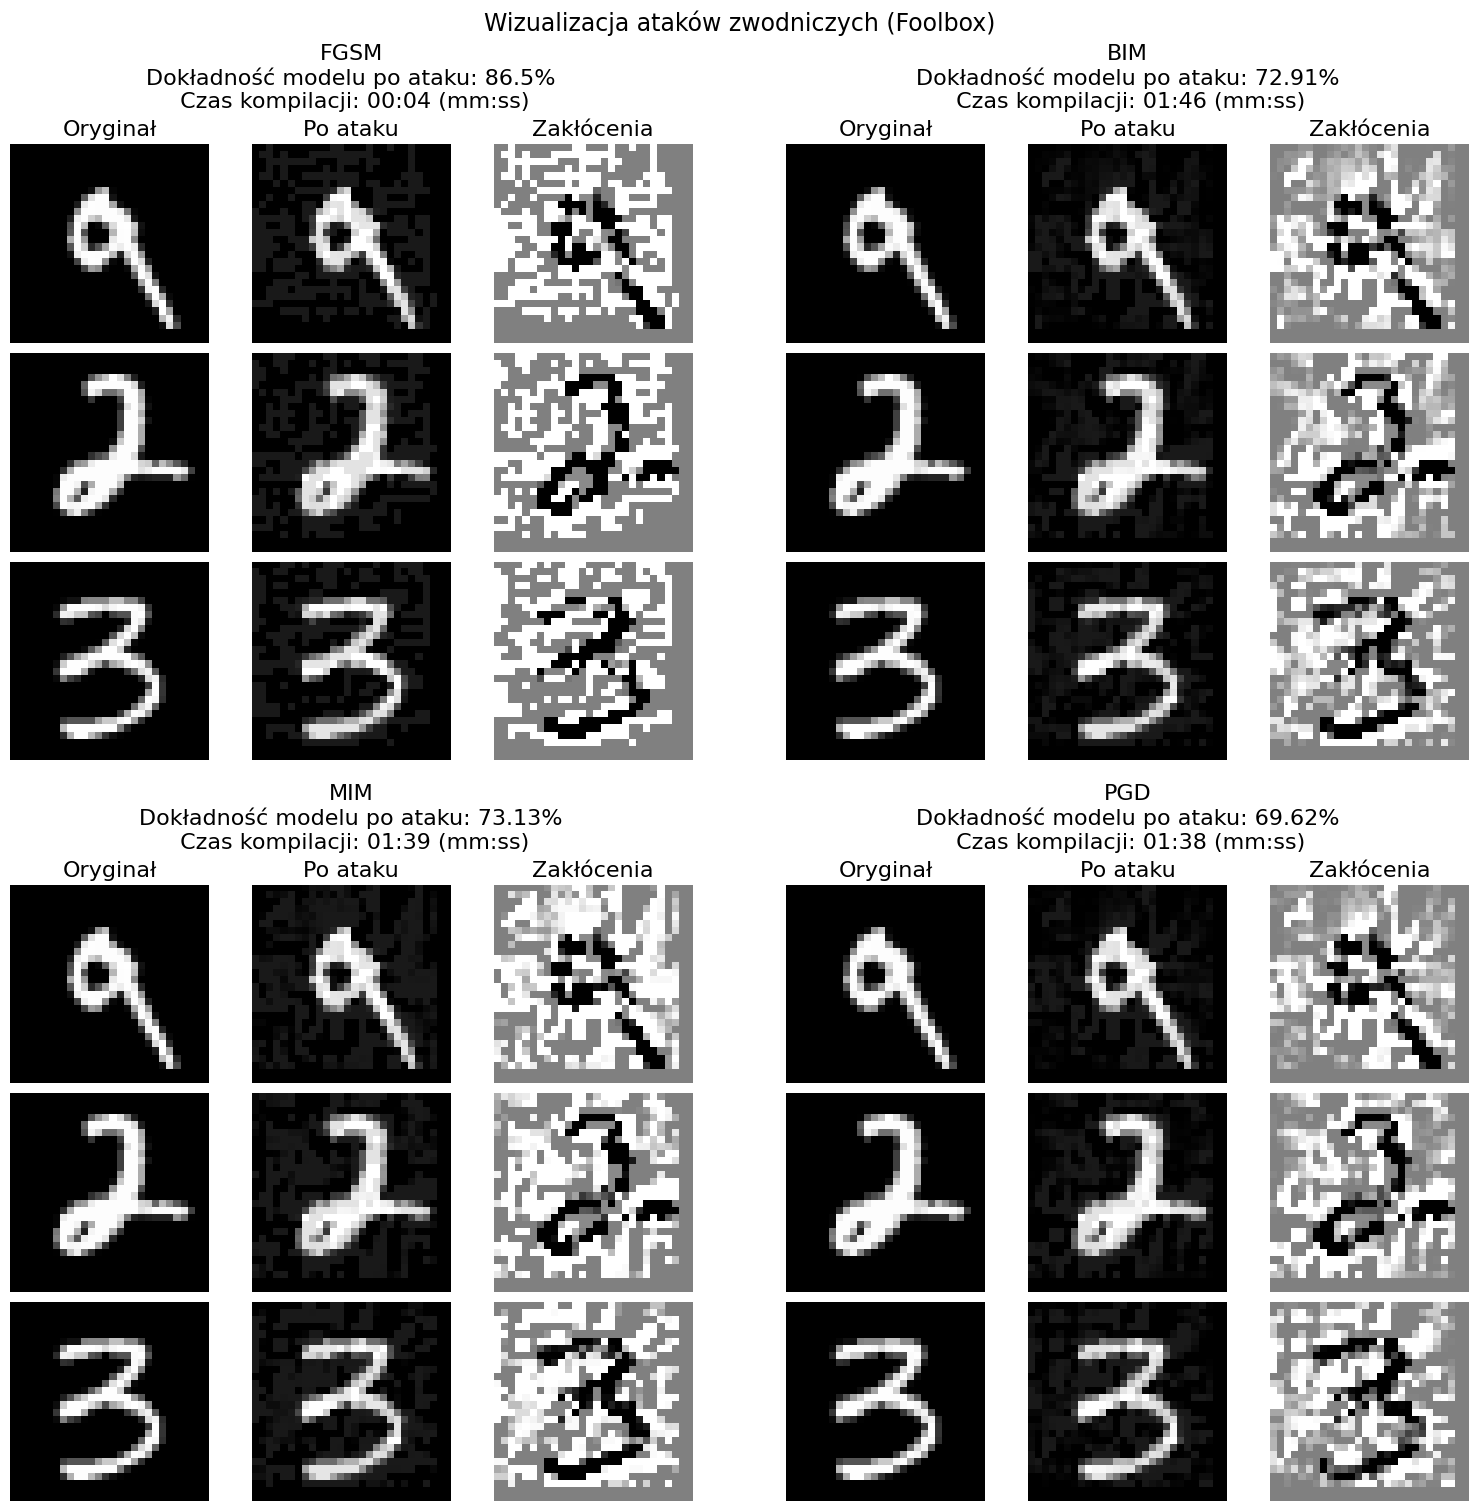

In [71]:
visualize_adversarial_attacks("Foolbox", x_test, x_adversarial_dict, attack_info, indices=[7, 396, 925])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


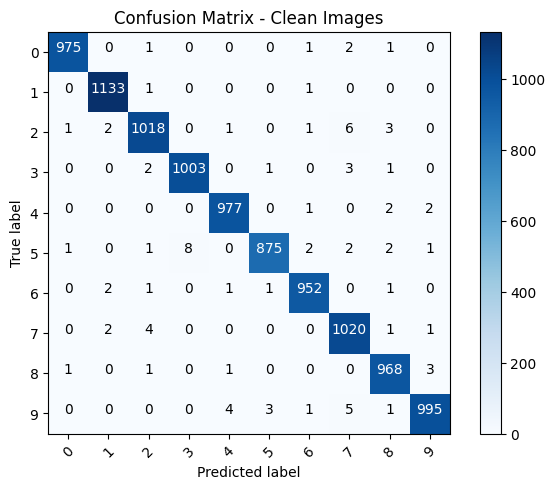

In [63]:
# Define the plot_confusion_matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Helper function to plot confusion matrix for each attack
def plot_attack_confusion_matrix(y_true, y_pred, attack_name):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=range(num_classes), title=f'Confusion Matrix - {attack_name}')

# Correctly extract the adversarial images and generate predictions
fgsm_adv_images = fgsm_adv['FGSM_adv'][0].numpy()  # Extract the first epsilon
fgsm_preds = np.argmax(loaded_mnist.predict(fgsm_adv_images), axis=1)

mim_adv_images = mim_adv['MIM_adv'][0].numpy()  # Extract the first epsilon
mim_preds = np.argmax(loaded_mnist.predict(mim_adv_images), axis=1)

pgd_adv_images = pgd_adv['PGD_adv'][0].numpy()  # Extract the first epsilon
pgd_preds = np.argmax(loaded_mnist.predict(pgd_adv_images), axis=1)

bim_adv_images = bim_adv['BIM_adv'][0].numpy()  # Extract the first epsilon
bim_preds = np.argmax(loaded_mnist.predict(bim_adv_images), axis=1)

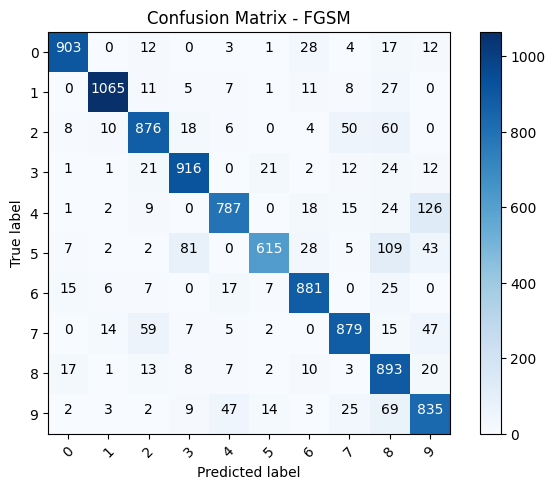

In [64]:
plot_attack_confusion_matrix(y_test, fgsm_preds, "FGSM")


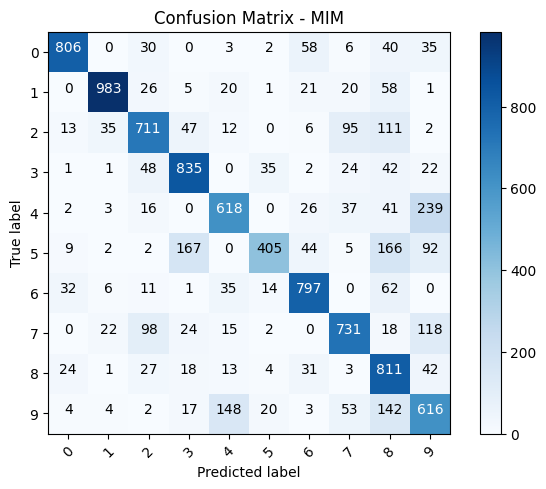

In [65]:
plot_attack_confusion_matrix(y_test, mim_preds, "MIM")


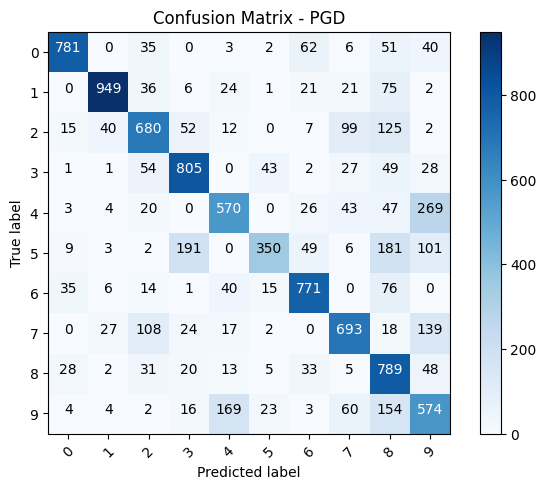

In [66]:
plot_attack_confusion_matrix(y_test, pgd_preds, "PGD")

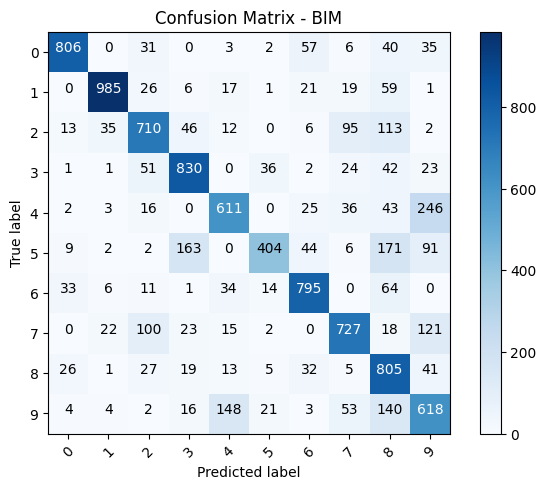

In [67]:
plot_attack_confusion_matrix(y_test, bim_preds, "BIM")

In [72]:
# Helper function to display top errors
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)), cmap='gray')
            ax[row, col].set_title("Pred: {}\nTrue: {}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Function to find and display the top 6 errors for each attack
def find_and_display_top_errors(x_test, y_test, adv_images, attack_name):
    y_test = y_test.numpy()
    y_pred = loaded_mnist.predict(adv_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    errors = (y_pred_classes - y_test != 0)
    y_pred_classes_errors = y_pred_classes[errors]
    y_pred_errors = y_pred[errors]
    y_true_errors = y_test[errors]
    x_val_errors = adv_images[errors]

    y_pred_errors_prob = np.max(y_pred_errors, axis=1)
    true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
    delta_pred_true_errors = y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    most_important_errors = sorted_dela_errors[-6:]

    display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

    # plt.suptitle(f'{attack_name}', size=16)
    # plt.subplots_adjust(top=0.85) 
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


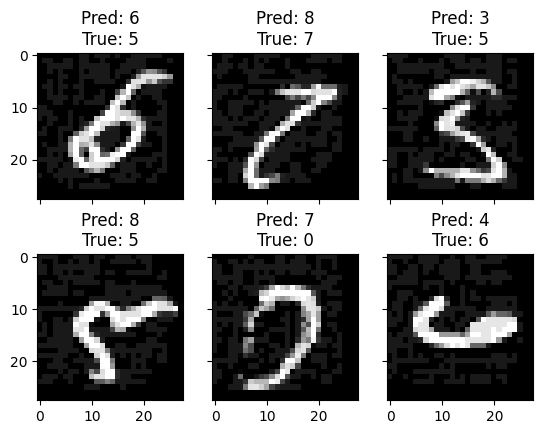

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


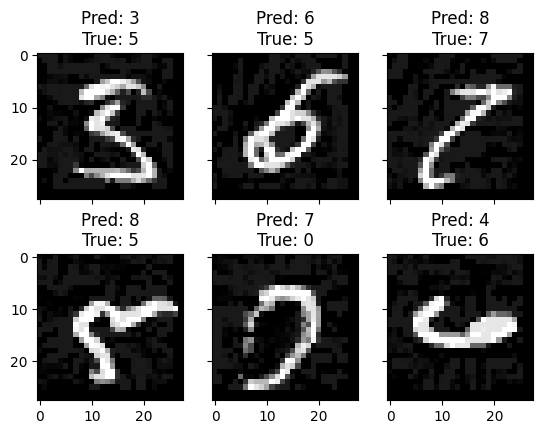

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


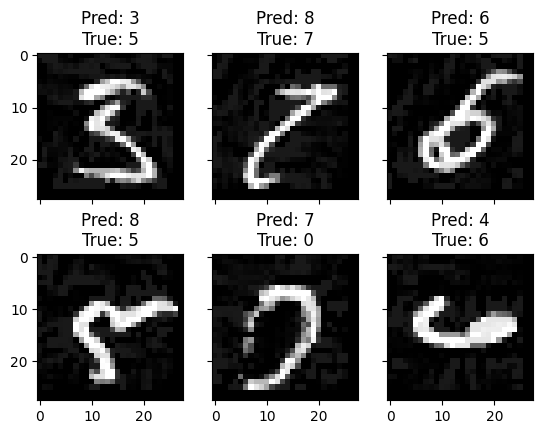

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


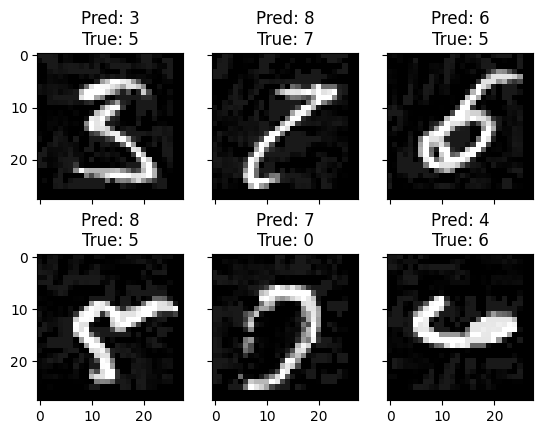

In [73]:
# Find and display the top 6 errors for each attack
find_and_display_top_errors(x_test, y_test_tf, fgsm_adv_images, "FGSM")
find_and_display_top_errors(x_test, y_test_tf, mim_adv_images, "MIM")
find_and_display_top_errors(x_test, y_test_tf, pgd_adv_images, "PGD")
find_and_display_top_errors(x_test, y_test_tf, bim_adv_images, "BIM")